# Multimodal information Guidance
Author Ilias Parmaksizoglou

This notebook provided a quick tour on how to use the Network Representation for Use-Cases: The needed input is:

* O-D matrix of randomized trips within the examined area
* OSM map of examined area in .graphml format


In [11]:
import osmnx as ox
import networkx as nx
import random 
import igraph as ig
import os
import time as tm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import os
from network_funcs import *

In [12]:
# Initialize globals
globals()["num_trips"] = 1000
globals()["timesteps"] = 60
globals()["period"] = 60
globals()["weight"] = ["travel_car","travel_train","speed_kph","length","lanes"]
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["g", "w","y","r"], N=256) 

In [13]:
def adjust_for_next_period(G_ig,dict_path,routes,initial_start,edges_dict_veh):
    for args in dict_path.items():
        idx = args[0][1]
        edge = G_ig.es[args[0][0]]
        if args[1][1] >= (step)*period and args[1][0]<= (step-1)*period:
            new_start_node = edge.target
            initial_start[idx] = args[1][1] # Fix re-computing to be executed only once
            index = routes[idx].index(new_start_node)
            routes[idx] = routes[idx][index:]
            steps_fill = step-1+math.ceil((args[1][1]-(step-1)*period)/period)
            step_range = range(step,steps_fill)
            for st in step_range:
                if (args[0][0],st) not in edges_dict_veh.keys(): 
                    edges_dict_veh[args[0][0],st] = 0
                edges_dict_veh[args[0][0],st] +=1
        elif edge.target == routes[idx][-1] and args[1][1] <= (step)*period:
            routes[idx] = []
            initial_start[idx] = -1
    return routes,initial_start,edges_dict_veh

In [14]:
def update_for_next_period(G_ig,dict_path,routes,initial_start,edges_dict_veh):
    for args in dict_path.items():
        idx = args[0][1]
        edge = G_ig.es[args[0][0]]
        if args[1][1] >= (step)*period and args[1][0]<= (step-1)*period:
            initial_start[idx] = args[1][1] # Fix re-computing to be executed only once
            routes[idx] = G_ig.get_shortest_paths(v=args[1][1], to=routes[idx][-1], weights="travel_car")[0]
            steps_fill = step-1+math.ceil((args[1][1]-(step-1)*period)/period)
            step_range = range(step,steps_fill)
            for st in step_range:
                if (args[0][0],st) not in edges_dict_veh.keys(): 
                    edges_dict_veh[args[0][0],st] = 0
                edges_dict_veh[args[0][0],st] +=1
        elif edge.target == routes[idx][-1] and args[1][1] <= (step)*period:
            routes[idx] = []
            initial_start[idx] = -1
    return routes,initial_start,edges_dict_veh

In [15]:
def generate_random_trips(G_ig,step,routes,initial_start,df,mode_split = 0.9):
    random.seed(step)

    # Handcrafted for Milano
    malpensa_xpress = [28168, 6499, 4912, 47496, 60959, 59253, 66380, 32154, 1078]
    airport_node = 4735

    for t in range(0,num_trips):
        idx_t = step*num_trips + t # Identifier of trip
        if np.random.rand() >=mode_split:
            opt_weight = "travel_train"
            if np.random.rand() >=0.5:
                orig = airport_node
                dest = random.choice(malpensa_xpress)
                starts = df.loc[orig,"starts_from_malpensa"].split(",")
            else:
                dest = airport_node
                orig = random.choice(malpensa_xpress)   
                starts = df.loc[orig,"starts_from_center"].split(",")      
            route = G_ig.get_shortest_paths(v=orig, to=dest, weights=opt_weight)[0]
            starts = df.loc[orig,"starts_from_"+"center"].split(",")
            starts = [int(x)-step if int(x)*60-step*period > 0 else np.inf for x in starts]
            initial_start[idx_t] = (min(starts)+step)*period
        else:
            opt_weight = "travel_car"
            if np.random.rand() >=0.5:
                orig = airport_node
                dest = random.choice(G_ig.vs).index
            else:
                dest = airport_node
                orig = random.choice(G_ig.vs).index
            route = G_ig.get_shortest_paths(v=orig, to=dest, weights=opt_weight)[0]
            initial_start[idx_t] = step*period 
        routes.append(route)
    return routes,initial_start



In [16]:
def update_dicts(G_ig,routes,initial_start,step,edges_dict_veh):
    dict_path = {}
    for idx_r,route in enumerate(routes):
        cur_time = initial_start[idx_r]
        for v in range(len(route)-1):
            edge_id = G_ig.get_eid(G_ig.vs[route[v]], G_ig.vs[route[v+1]])
            duration = min(G_ig.es[edge_id][weight[0]],G_ig.es[edge_id][weight[1]])
            dict_path[edge_id,idx_r] = (round(cur_time,2) ,round(cur_time+duration,2))
            
            if (edge_id,step) not in edges_dict_veh.keys(): 
                edges_dict_veh[edge_id,step] = 0

            if (step)*period <= round(cur_time,2) and (step+1)*period > round(cur_time,2):
                edges_dict_veh[edge_id,step]+=1

            cur_time+=duration
    edges_dict_veh = {x:y for x,y in edges_dict_veh.items() if y!=0}
    return dict_path,edges_dict_veh


In [17]:
def update_gdfs(G_ig,gdf_edges,edges_dict_veh,step,max_speed):

    # Update speeds of edges
    edges_passengers = [0]*len(G_ig.es)
    edges_speed_drop = [0]*len(G_ig.es)
    edges_density = [0]*len(G_ig.es)
    edges_travel_car = list(G_ig.es["travel_car"])
    edges_speed = list(G_ig.es["speed_kph"])
    gdf_edges["passengers"] = 0
    gdf_edges["density"] = 0
    gdf_edges["speed_drop"] = 0
    for edge in G_ig.es:
        index = edge.index
        if (index,step) in edges_dict_veh.keys():
            if edge['travel_train'] < edge['travel_car']:
                passengers = edges_dict_veh[index,step]
                density = round(passengers/500,2)
                speed = round(999,1)
                travel_car = edge["travel_car"]
            else:
                passengers = edges_dict_veh[index,step]
                density =  round(passengers/(edge['length']+1e-2),2)
                speed = round(max(0.1,max_speed[index]*(1-(density/(0.15*edge['lanes'])))),1)
                travel_car = edge['length']/(speed+0.01)
                gdf_edges.at[(edge.source,edge.target,0),"speed_drop"]= 1-speed/max_speed[index]
                gdf_edges.at[(edge.source,edge.target,0),"travel_car"]= travel_car     
        else:
            passengers = 0
            density = 0
            speed = round(edge["speed_kph"],1)
            travel_car = edge["travel_car"]
            gdf_edges.at[(edge.source,edge.target,0),"speed_drop"]
        gdf_edges.at[(edge.source,edge.target,0),"passengers"] = passengers
        gdf_edges.at[(edge.source,edge.target,0),"density"] = density
        gdf_edges.at[(edge.source,edge.target,0),"speed_kph"]= speed
        edges_passengers[index] = passengers
        edges_density[index] =density
        edges_speed[index] = speed
        #edges_travel_car[index] = travel_car
    G_ig.es['passengers'] = edges_passengers
    G_ig.es['density'] = edges_density
    G_ig.es['speed_kph'] = edges_speed
    G_ig.es['travel_car'] = edges_travel_car
    return G_ig,gdf_edges

In [18]:
# Initializing working directory and files
core_dir = os.path.join(os.getcwd(),"core\maps")
area_name = "delft"
area = f"{area_name}.graphml"

# Loading OSM map from file
G = ox.load_graphml(os.path.join(core_dir,area))

# Transforming to Igraph
G,G_ig = transform_nx_to_igragh(G)
gdf_nodes,gdf_edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)

# Retaining edge info from Networkx
max_speed = get_max_speed(G_ig)

# Loading train schedule if it exists
df = load_train_schedule(name="train_schedule.xlsx")

C:\Users\iparm\AppData\Local\Temp\ipykernel_20624\1910851331.py:32: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:442
  route = G_ig.get_shortest_paths(v=orig, to=dest, weights=opt_weight)[0]


Time in timestep 1 : 6.407006502151489
Time in timestep 2 : 6.577016115188599


C:\Users\iparm\AppData\Local\Temp\ipykernel_20624\1910851331.py:32: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:442
  route = G_ig.get_shortest_paths(v=orig, to=dest, weights=opt_weight)[0]


Time in timestep 3 : 6.834436416625977


C:\Users\iparm\AppData\Local\Temp\ipykernel_20624\1910851331.py:32: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:442
  route = G_ig.get_shortest_paths(v=orig, to=dest, weights=opt_weight)[0]


Time in timestep 4 : 7.348341464996338


C:\Users\iparm\AppData\Local\Temp\ipykernel_20624\1910851331.py:32: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:442
  route = G_ig.get_shortest_paths(v=orig, to=dest, weights=opt_weight)[0]


Time in timestep 5 : 7.132683515548706


C:\Users\iparm\AppData\Local\Temp\ipykernel_20624\1910851331.py:32: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:442
  route = G_ig.get_shortest_paths(v=orig, to=dest, weights=opt_weight)[0]


Time in timestep 6 : 7.299027919769287


C:\Users\iparm\AppData\Local\Temp\ipykernel_20624\1910851331.py:32: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:442
  route = G_ig.get_shortest_paths(v=orig, to=dest, weights=opt_weight)[0]


Time in timestep 7 : 7.628835201263428


C:\Users\iparm\AppData\Local\Temp\ipykernel_20624\1910851331.py:32: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:442
  route = G_ig.get_shortest_paths(v=orig, to=dest, weights=opt_weight)[0]


Time in timestep 8 : 7.443749904632568


KeyboardInterrupt: 

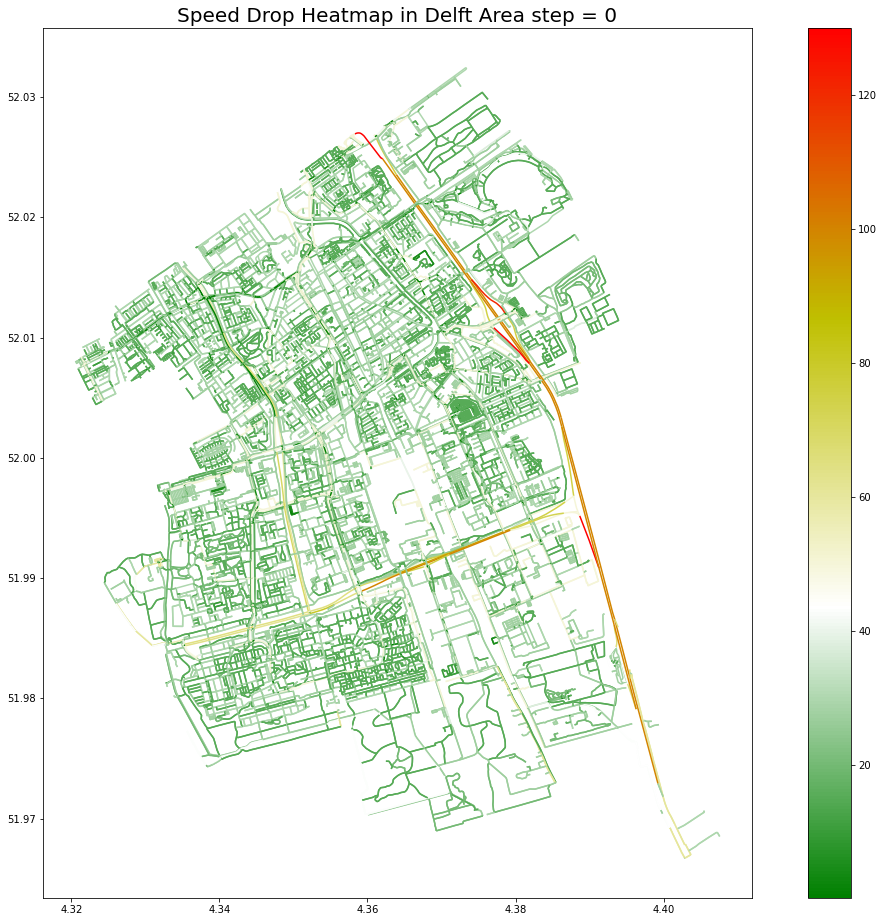

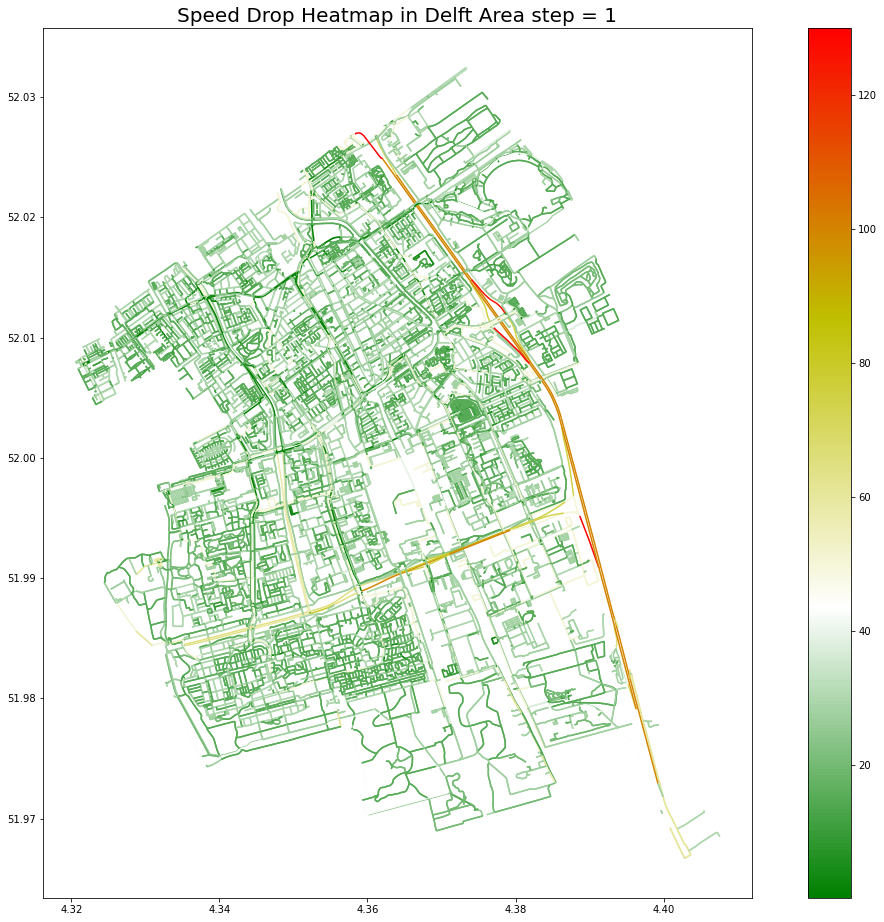

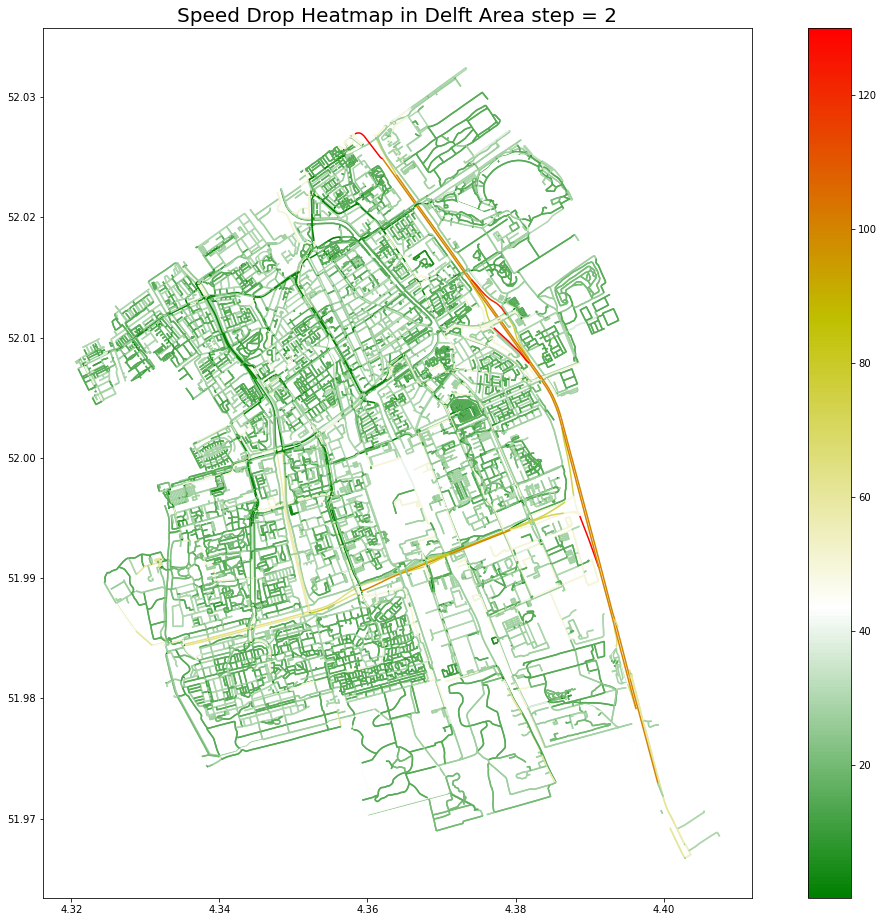

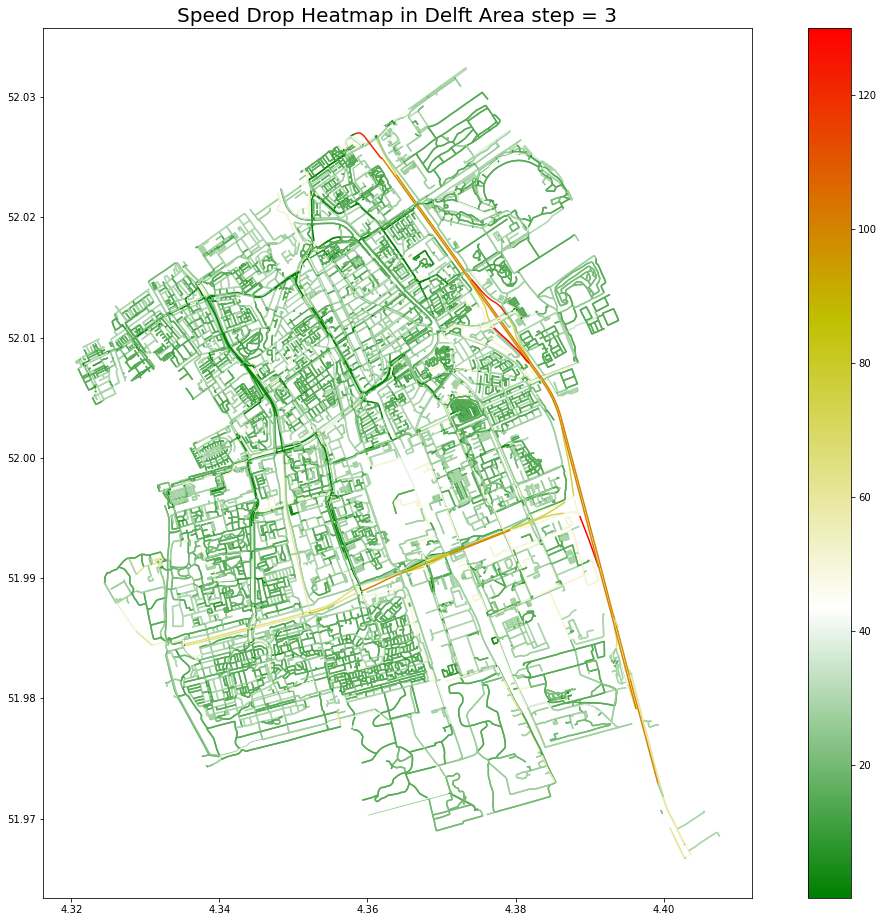

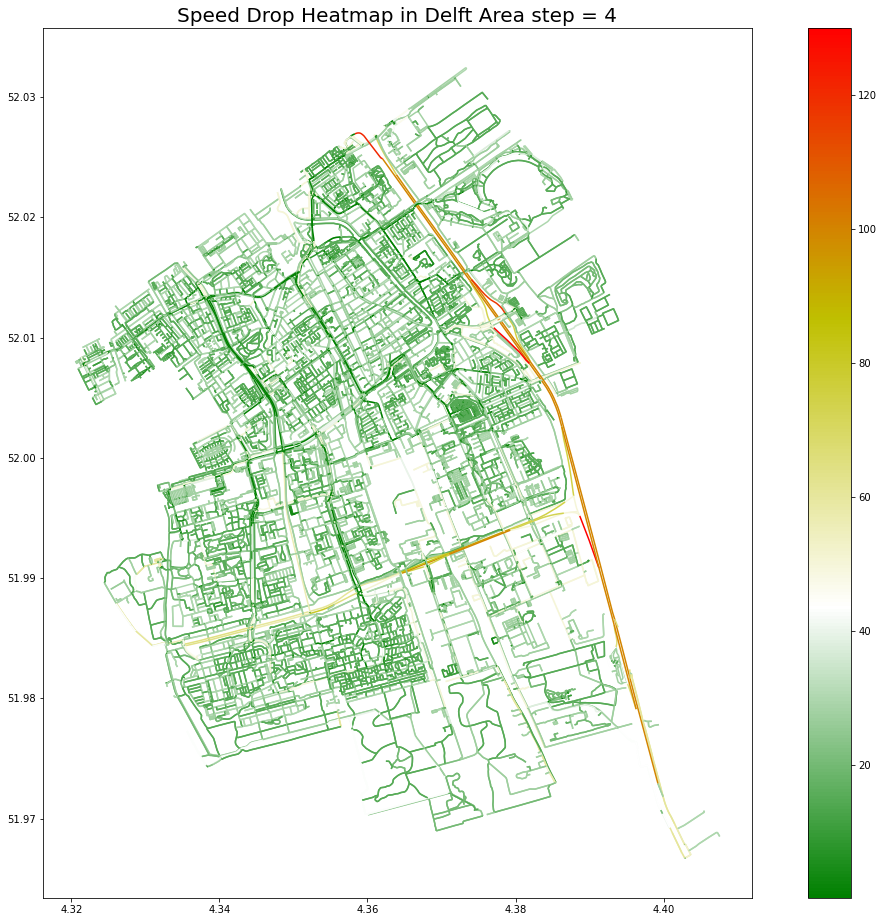

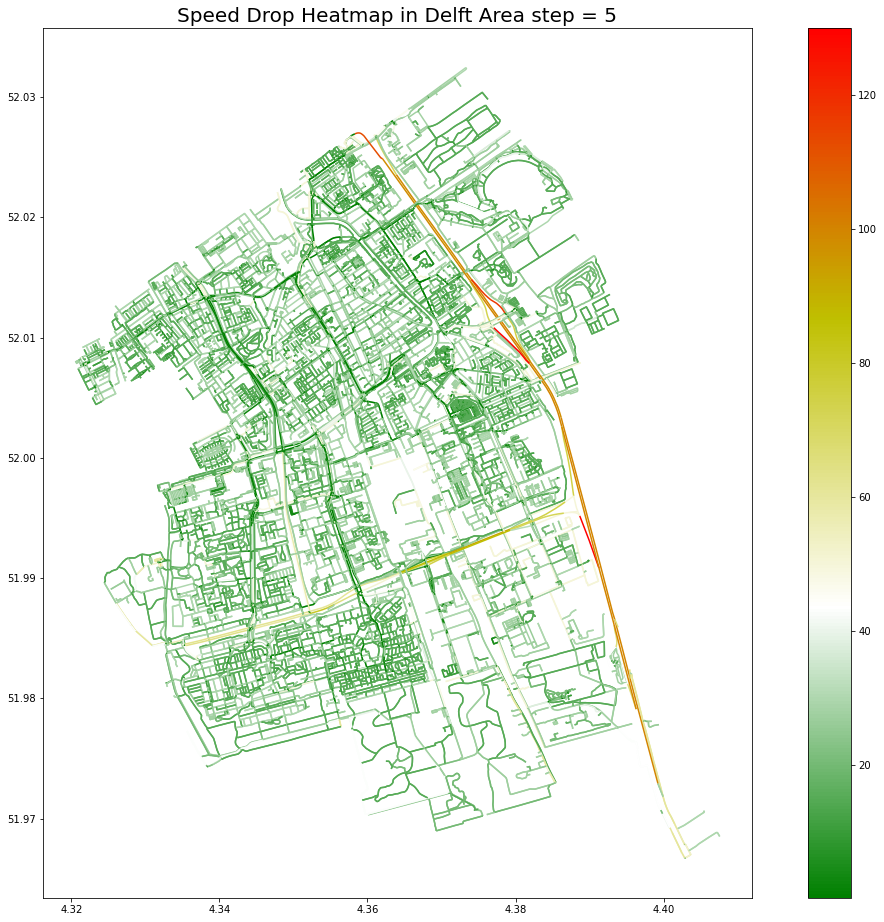

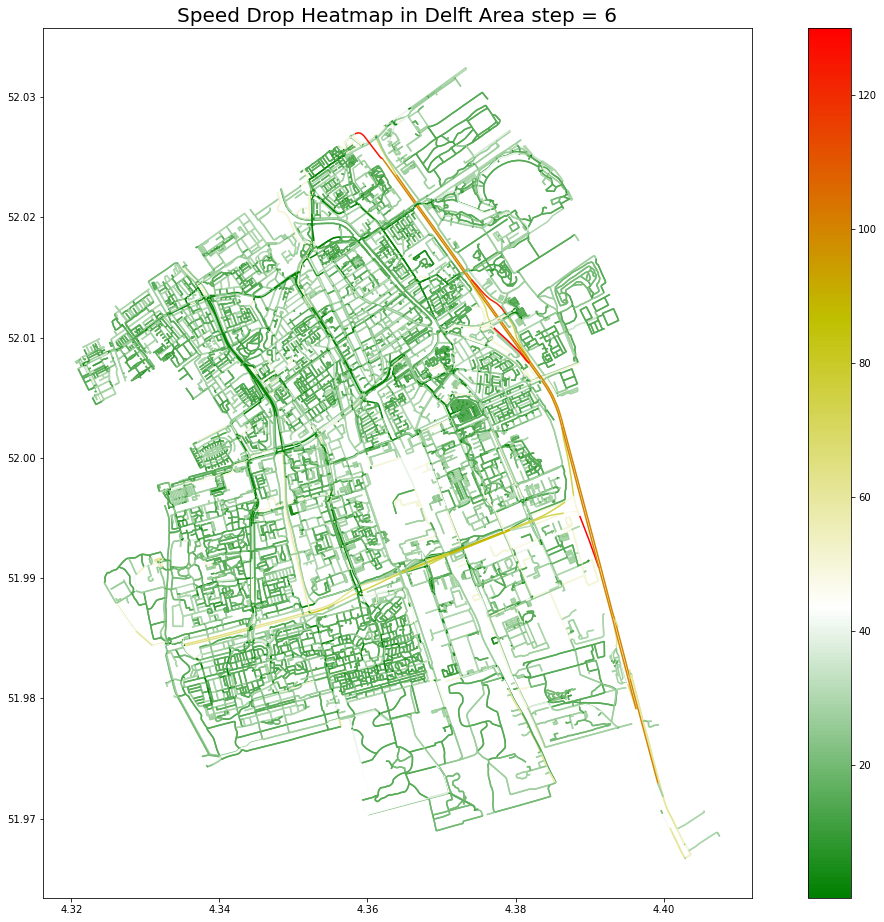

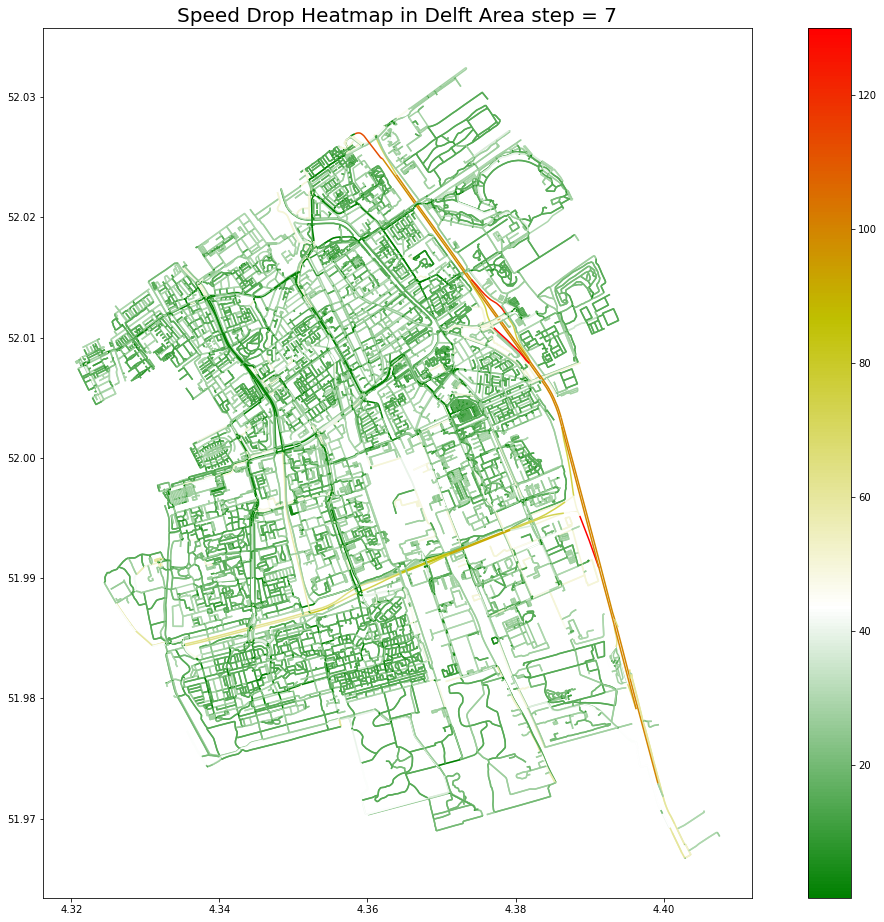

In [19]:
# Initialize Dictionaries and Lists
routes = [] # List of Networkx routes in the map (Vertex-to-Vertex)
initial_start = {}
edges_speed = {}
edges_time = {}
edges_dict_veh = {}
for step in range(timesteps):

    # Step 0 - Adjust route based on next time step
    step1 = tm.time()
    if step == 0:
        pass
    else:
        routes,initial_start,edges_dict_veh = adjust_for_next_period(G_ig,dict_path,routes,initial_start,edges_dict_veh)

    # Step 1 - Generate new routes
    routes,initial_start = generate_random_trips(G_ig,step,routes,initial_start,df,mode_split=1.0)

    # Step 2 - Update dict_path edges and number of vehicles
    dict_path,edges_dict_veh = update_dicts(G_ig,routes,initial_start,step,edges_dict_veh)

    # Step 3 - Update gdf_edges 
    G_ig,gdf_edges = update_gdfs(G_ig,gdf_edges,edges_dict_veh,step,max_speed)
    
    # #Step 4 Plot with Networkx
    fig_heatmap1 = plt.figure(figsize=(20,16))
    ax_heatmap1 = plt.axes()
    ax_heatmap1.set(facecolor = "white")
    ax_heatmap1.set_title("Speed Drop Heatmap in Delft Area step = {}".format(step), fontsize=20)
    gdf_edges.plot(ax=ax_heatmap1, cmap=cmap, column="speed_kph", legend=True)
    core_dir = os.path.join(os.getcwd(),"core\pics")
    plt.savefig(f"{core_dir}\step{step+1}",dpi=125)
    step2 = tm.time()
    print(f"Time in timestep {step+1} : {step2-step1}")


In [ ]:
save_to_gif()